In [11]:
import re
import pandas as pd
import numpy as np
from collections import defaultdict
from numba import jit, cuda 

# Set Pandas to display all rows of dataframes
pd.set_option('display.max_rows', 500)

# nltk
from nltk import tokenize

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Plotting tools
import matplotlib.pyplot as plt
import matplotlib
plt.style.use('fivethirtyeight')
%matplotlib inline

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

from tqdm import tqdm_notebook as tqdm
from tqdm import trange

In [12]:
# Book number and corresponding file size
numbers = ["01","02","03","04","05","06","07","08","09","10","11","12","13","14","15","16","17","18"]
sizes = [1336,454,1871,365,1098,959,1487,811,539,124,127,3130,1706,525,192,47,18,51]

In [13]:
sections = pd.read_csv("Mahabharata/sections.csv")
words = pd.read_csv("Mahabharata/words.csv")
sections.head()

,section_num,section,book_title,book_num
0,1,I\n\nOm! Having bowed down to Narayana and Na...,ADI PARVA,1
1,2,"II\n\n""The Rishis said, 'O son of Suta, we wi...",ADI PARVA,1
2,3,"III\n\n(Paushya Parva)\n\nSauti said, ""Janame...",ADI PARVA,1
3,4,"IV\n\n(Pauloma Parva)\n\n'UGRASRAVA SAUTI, th...",ADI PARVA,1
4,5,"V\n\n(Pauloma Parva continued)\n\n""Saunaka sa...",ADI PARVA,1


In [15]:
numberOfWordsDict = {}
for i in range(1,19):
    bookPath = "Mahabharata/data/mhbhrt/maha"+numbers[i-1]+".txt"
    file = open(bookPath, "rt")
    data = file.read()
    words = data.split()
    numberOfWordsDict[i] = (len(words))
print(numberOfWordsDict )

{1: 230700, 2: 77092, 3: 326528, 4: 62923, 5: 190169, 6: 161532, 7: 251665, 8: 138358, 9: 91659, 10: 21375, 11: 21870, 12: 536641, 13: 299867, 14: 89347, 15: 32740, 16: 8094, 17: 3074, 18: 8654}


In [14]:
words.head()

,Unnamed: 0,word_num,word,sentence_num,section_num,book_title,book_num,lemma,POS,stop
0,0,1,I,1,1,ADI PARVA,1,-PRON-,PRON,True
1,1,1,Om,2,1,ADI PARVA,1,Om,PROPN,False
2,2,2,!,2,1,ADI PARVA,1,!,PUNCT,False
3,3,1,Having,3,1,ADI PARVA,1,have,VERB,False
4,4,2,bowed,3,1,ADI PARVA,1,bow,VERB,False


In [16]:
sections['section'] = sections.section.str.replace("\n", " ")

In [17]:
chaptersDict = {}
bookTitles = []
for i in range(len(sections)):
    bookTitles.append(sections.loc[i]['book_title'])
bookTitles = list(set(bookTitles))
bookTitles

['SANTI PARVA',
 'BHISHMA PARVA',
 'MAHAPRASTHANIKA PARVA',
 'ADI PARVA',
 'DRONA PARVA',
 'STRI-PARVA',
 'VANA PARVA',
 'ASRAMAVASIKA PARVA',
 'SVARGAROHANIKA-PARVA',
 'KARNA-PARVA',
 'SABHA PARVA',
 'SHALYA-PARVA',
 'MAUSALA-PARVA',
 'UDYOGA PARVA',
 'ANUSASANA PARVA',
 'SAUPTIKA-PARVA',
 'ASWAMEDHA PARVA',
 'VIRATA PARVA']

In [18]:
for i in range(len(bookTitles)):
    bookContent = ""
    for j in range(len(sections)):
        if(sections.loc[j]['book_title'] is bookTitles[i]):
            bookContent+=sections.loc[j]['section']
    chaptersDict[bookTitles[i]] = bookContent

In [19]:
analyzer = SentimentIntensityAnalyzer()

In [20]:
import time

In [28]:
sentimentsDictionary = {}
wordsvsTime = {}
sizevsTime = {}
i = 0
for book_name,content in tqdm(chaptersDict.items(),desc='Progress'):
    sentence_list = tokenize.sent_tokenize(content)
    sentiments = {'compound': 0.0, 'neg': 0.0, 'neu': 0.0, 'pos': 0.0}
    start = time.time()
    for sentence in sentence_list:
            vs = analyzer.polarity_scores(sentence)
            sentiments['compound'] += vs['compound']
            sentiments['neg'] += vs['neg']
            sentiments['neu'] += vs['neu']
            sentiments['pos'] += vs['pos']
    end = time.time()
    sentiments['compound'] = sentiments['compound'] / len(sentence_list)
    sentiments['neg'] = sentiments['neg'] / len(sentence_list)
    sentiments['neu'] = sentiments['neu'] / len(sentence_list)
    sentiments['pos'] = sentiments['pos'] / len(sentence_list)
    sentimentsDictionary[book_name] = sentiments
    timeTaken = end-start
    sizevsTime[sizes[i]] = timeTaken
    wordsvsTime[len(content)] = timeTaken
    print(i,sizes[i],len(content),timeTaken)
    i+=1

0 1336 3151180 3.7910892963409424
1 454 965354 1.1962149143218994
2 1871 17792 0.04378104209899902
3 365 1332583 1.6022100448608398
4 1098 1497942 2.0203709602355957
5 959 127091 0.15926218032836914
6 1487 1883480 2.5327706336975098
7 811 192390 0.24644184112548828
8 539 50758 0.07859230041503906
9 124 817490 0.985314130783081
10 127 456272 0.5764148235321045
11 3130 542366 0.7233076095581055
12 1706 47102 0.049215078353881836
13 525 1105719 1.5397944450378418
14 192 1718249 2.7636454105377197
15 47 124464 0.18728280067443848
16 18 528066 0.6115953922271729
17 51 366530 0.44457149505615234



In [31]:
print(sizevsTime)
print(wordsvsTime)

{1336: 3.7910892963409424, 454: 1.1962149143218994, 1871: 0.04378104209899902, 365: 1.6022100448608398, 1098: 2.0203709602355957, 959: 0.15926218032836914, 1487: 2.5327706336975098, 811: 0.24644184112548828, 539: 0.07859230041503906, 124: 0.985314130783081, 127: 0.5764148235321045, 3130: 0.7233076095581055, 1706: 0.049215078353881836, 525: 1.5397944450378418, 192: 2.7636454105377197, 47: 0.18728280067443848, 18: 0.6115953922271729, 51: 0.44457149505615234}
{3151180: 3.7910892963409424, 965354: 1.1962149143218994, 17792: 0.04378104209899902, 1332583: 1.6022100448608398, 1497942: 2.0203709602355957, 127091: 0.15926218032836914, 1883480: 2.5327706336975098, 192390: 0.24644184112548828, 50758: 0.07859230041503906, 817490: 0.985314130783081, 456272: 0.5764148235321045, 542366: 0.7233076095581055, 47102: 0.049215078353881836, 1105719: 1.5397944450378418, 1718249: 2.7636454105377197, 124464: 0.18728280067443848, 528066: 0.6115953922271729, 366530: 0.44457149505615234}


[(17792, 0.04378104209899902), (47102, 0.049215078353881836), (50758, 0.07859230041503906), (124464, 0.18728280067443848), (127091, 0.15926218032836914), (192390, 0.24644184112548828), (366530, 0.44457149505615234), (456272, 0.5764148235321045), (528066, 0.6115953922271729), (542366, 0.7233076095581055), (817490, 0.985314130783081), (965354, 1.1962149143218994), (1105719, 1.5397944450378418), (1332583, 1.6022100448608398), (1497942, 2.0203709602355957), (1718249, 2.7636454105377197), (1883480, 2.5327706336975098), (3151180, 3.7910892963409424)]


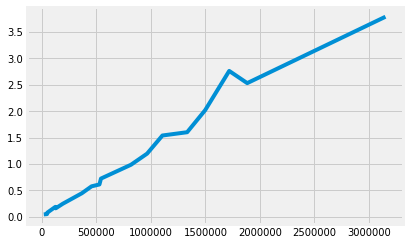

In [32]:
#The graph below shows number of words vs time taken to process
import matplotlib.pylab as plt

lists = sorted(wordsvsTime.items())
print(lists)
x, y = zip(*lists) 
plt.plot(x, y)
plt.show()

[(18, 0.6115953922271729), (47, 0.18728280067443848), (51, 0.44457149505615234), (124, 0.985314130783081), (127, 0.5764148235321045), (192, 2.7636454105377197), (365, 1.6022100448608398), (454, 1.1962149143218994), (525, 1.5397944450378418), (539, 0.07859230041503906), (811, 0.24644184112548828), (959, 0.15926218032836914), (1098, 2.0203709602355957), (1336, 3.7910892963409424), (1487, 2.5327706336975098), (1706, 0.049215078353881836), (1871, 0.04378104209899902), (3130, 0.7233076095581055)]


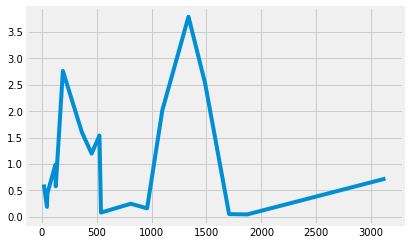

In [33]:
#This shows file size in kiloBytes vs Time taken to process
import matplotlib.pylab as plt

lists = sorted(sizevsTime.items())
print(lists)
x, y = zip(*lists) 
plt.plot(x, y)
plt.show()